In [1]:
import tensorflow_hub as hub
import tensorflow as tf

import matplotlib.pyplot as plt
import urllib.request as ur
import pandas as pd
import numpy as np
import itertools
import skimage
import pickle
import glob
import json
import ast
import cv2
import re

from skimage import data, io
from skimage.segmentation import flood, flood_fill
from collections import Counter
from sklearn.manifold import TSNE
from pandas.io.json import json_normalize
from matplotlib import cm
from utils import read_config
from pathlib import Path
from copy import deepcopy
from tqdm import tqdm
from yolov4.tf import YOLOv4

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
config = read_config("config.json")
config['dataset_path'] = Path(config['dataset_path'])

In [4]:
videos_df = pd.read_pickle(config['dataset_path'] / 'chkp1.pkl')
print(videos_df.shape)
videos_df.head(3)

(8606, 84)


,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,...,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash
10,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,2017-11-13 02:05:26+00:00,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,...,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[-0.011210336349904537, -0.02326270006597042, ...",-3.408266e+10
36,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,2017-11-12 18:00:03+00:00,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,...,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.046388525515794754, 0.05515308678150177, -0...",-7.891112e+10
41,goP4Z5wyOlM,2017-11-14,Iraq-Iran earthquake: Deadly tremor hits borde...,BBC News,2017-11-12 21:16:40+00:00,"bbc|""bbc news""|""news""|""iran""|""iran news""|""iraq...",34785,308,26,413,...,90.0,2,6.0,0.066667,0.132075,0.160542,0.571429,"[-0.026162145659327507, 0.023051297292113304, ...","[0.010515631176531315, 0.1938595026731491, -0....",-2.124116e+10


In [5]:
videos_df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'publish_time',
       'tags', 'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description', 'origin', 'category_id', 'category_text',
       'publish_time_day', 'publish_time_month', 'publish_time_year',
       'publish_time_weekday', 'publish_time_quarter', 'publish_time_hour',
       'publish_time_minute', 'publish_time_second', 'trending_date_day',
       'trending_date_month', 'trending_date_year', 'trending_date_weekday',
       'trending_date_quarter', 'trending_date_end', 'trending_date_start',
       'trending_span', 'trending_span_days', 'publish_to_trending_span',
       'publish_to_trending_span_in_hours', 'likes_first', 'likes_last',
       'likes_diff', 'dislikes_first', 'dislikes_last', 'dislikes_diff',
       'views_first', 'views_last', 'views_diff', 'comment_count_first',
       'comment_count_last', 'comment_

In [6]:
videos_df = deepcopy(videos_df[['video_id', 'thumbnail_link', 'category_text']])
videos_df.drop_duplicates(inplace=True)
videos_df.set_index('video_id', inplace=True)
print(videos_df.shape)
videos_df.head(3)

(8606, 2)


,thumbnail_link,category_text
video_id,,
9wRQljFNDW8,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,NaN
Om_zGhJLZ5U,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,NaN
goP4Z5wyOlM,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,NaN


### Download images

Wyjątki - Są to filmy, które nie są dostępne (np. są prywatne), przykładem kanału z takim filmem jest The View, który postuje filmy z różnych programów telewizyjnych. Takie filmy mogą być obiektem roszczeń o prawa autorskie, pomimo tego, że były trending i ich thumbnaile będą niedostępne.

In [7]:
# count_unknown = 0
# for index, row in videos_df.iterrows():
#     path = config['dataset_path'] / 'images/{}.jpg'.format(row['video_id'])
#     link = re.sub(r'(default)', r'hq\1', row['thumbnail_link'])
#     try:
#         ur.urlretrieve(link, path)
#     except:
#         
#         count_unknown += 1
# count_unknown

### Thumbnail embedding

In [8]:
def mod_img(df, func, colname='', *args):
    col_val_list = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            col_val_list.append(func(index, *args))
        except UnicodeDecodeError:
            col_val_list.append(np.NaN)
    # Add to dataframe
    df[colname] = col_val_list
    return df

![https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html](https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s640/image3.png)

In [9]:
feature_ex_model = hub.load("https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1")

In [10]:
def fv_func(index, *args):
    max_dim = 512
    # Read img
    img = tf.io.read_file('data/images/{}.jpg'.format(index))
    img = tf.image.decode_image(img, channels=3)
    # Preprocess img (scale to max_dim)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    new_shape = tf.cast(shape * (max_dim / max(shape)), tf.int32) # shape * scale
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return np.squeeze(feature_ex_model(img).numpy())

# Reduce df size for testing purposes (and remove rows with nans)
# videos_df = videos_df.dropna()
# videos_df = videos_df.head(50)

# videos_df = mod_img(videos_df, fv_func, colname='feature_vector')
videos_df = pd.read_pickle('data/fv_videos_df.pkl')
print(videos_df.shape)
videos_df.head(3)

(8606, 3)


,thumbnail_link,category_text,feature_vector
video_id,,,
9wRQljFNDW8,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,NaN,"[0.06580926, -0.12843476, -0.04167219, -0.0986..."
Om_zGhJLZ5U,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,NaN,"[0.00328945, -0.09353591, 0.4361128, -0.185314..."
goP4Z5wyOlM,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,NaN,"[0.33117568, 0.068013296, 0.3588107, -0.179159..."


In [11]:
tensor = videos_df['feature_vector'].values

In [12]:
tensor

array([array([ 0.06580926, -0.12843476, -0.04167219, ..., -0.10349274,
       -0.14756769, -0.01891625], dtype=float32),
       array([ 0.00328945, -0.09353591,  0.4361128 , ...,  0.2592871 ,
       -0.13721035, -0.04288537], dtype=float32),
       array([0.33117568, 0.0680133 , 0.3588107 , ..., 0.06841249, 0.03805888,
       0.00631504], dtype=float32),
       ...,
       array([ 0.11037743, -0.10578129,  0.37940934, ...,  0.15567924,
       -0.12508784, -0.12738986], dtype=float32),
       array([ 0.03912545, -0.14649555,  0.48778644, ...,  0.02884086,
       -0.19759433, -0.12109306], dtype=float32),
       array([ 0.3024939 , -0.11728705,  0.58624357, ...,  0.20107388,
       -0.14625709, -0.1130297 ], dtype=float32)], dtype=object)

### t-SNE projection

In [13]:
videos_df = videos_df.dropna()
tsne_fv = videos_df['feature_vector'].values
tsne_fv = np.stack(tsne_fv, axis=0)
tsne_fv.shape

(2598, 2560)

In [14]:
tsne_cat = videos_df['category_text'].values
tsne_cat

array(['Comedy', 'Music', 'Gaming', ..., 'Music', 'Music',
       'Entertainment'], dtype=object)

In [15]:
unique_cat = list(set(videos_df.category_text.values))
unique_cat

['Gaming',
 'Nonprofits & Activism',
 'Entertainment',
 'Howto & Style',
 'Autos & Vehicles',
 'Science & Technology',
 'Comedy',
 'Pets & Animals',
 'Shows',
 'Music',
 'People & Blogs',
 'News & Politics',
 'Education',
 'Film & Animation',
 'Travel & Events',
 'Sports']

In [16]:
tsne = TSNE(n_components=2, verbose=1).fit_transform(tsne_fv)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2598 samples in 0.007s...
[t-SNE] Computed neighbors for 2598 samples in 0.604s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2598
[t-SNE] Computed conditional probabilities for sample 2000 / 2598
[t-SNE] Computed conditional probabilities for sample 2598 / 2598
[t-SNE] Mean sigma: 2.492716
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.184479
[t-SNE] KL divergence after 1000 iterations: 2.154495


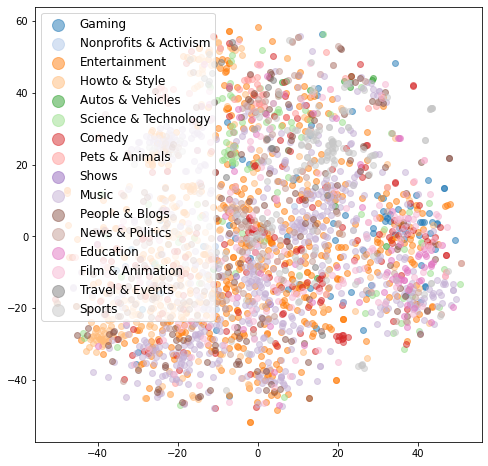

In [17]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))

for i, cat in enumerate(unique_cat):
    idx = tsne_cat == cat
    ax.scatter(
        tsne[idx, 0],
        tsne[idx, 1],
        c = np.array(cmap(i)).reshape(1,4),
        label = cat,
        alpha = 0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

### Object detection with YOLO

In [18]:
# Initialize YOLO v4
yolo = YOLOv4()

yolo.config.parse_names("data/yolo_data/coco.names")
yolo.config.parse_cfg("data/yolo_data/yolov4-tiny.cfg")
yolo.make_model()
yolo.load_weights("data/yolo_data/yolov4-tiny.weights", weights_type="yolo")
# yolo.summary(summary_type="yolo")

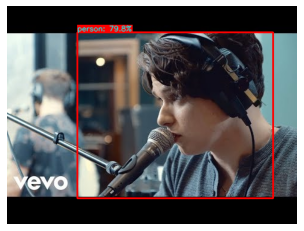

In [19]:
# Example
frame = cv2.imread("data/images/__-22AJoFxY.jpg")
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(yolo.draw_bboxes(frame_rgb, yolo.predict(frame_rgb, prob_thresh=0.25)))

In [20]:
def apply_yolo(index, prob_thresh=0.25):
    frame = cv2.imread("data/images/{}.jpg".format(index))
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pred = yolo.predict(frame_rgb, prob_thresh=prob_thresh)
    objects = []
    max_prob_object = (np.nan, -1)
    for i in pred:
        cx, cy, hw, hh, label_id, prob = i
        if prob > prob_thresh:
            object_ = yolo.config.names[label_id]
            objects.append(object_)
            if prob > max_prob_object[1]: max_prob_object = (object_, prob)
    c = Counter(objects)
    try:
        most_common = c.most_common(1)[0][0]
    except IndexError:
        most_common = np.nan
    return c['person'], objects, max_prob_object, most_common

videos_df = mod_img(videos_df, apply_yolo, colname=['people_amount', 'objects', 'max_prob_object', 'most_occurence_object'])
videos_df.head(5)

100%|██████████| 2598/2598 [03:33<00:00, 12.16it/s]
c:\Users\N0tE\Documents\Github\yt_trending_videos\venv\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,thumbnail_link,category_text,feature_vector,people_amount,objects,max_prob_object,most_occurence_object
video_id,,,,,,,
wnwF1FHybDQ,https://i.ytimg.com/vi/wnwF1FHybDQ/default.jpg,Comedy,"[0.61984324, -0.023169093, -0.16509528, -0.129...",2,"[person, person]","(person, 0.43971124)",person
1Wk8ZRgXQnY,https://i.ytimg.com/vi/1Wk8ZRgXQnY/default.jpg,Music,"[0.071150824, -0.1588716, 0.070787266, -0.1663...",0,[],"(nan, -1)",NaN
lsfzA7sWlOM,https://i.ytimg.com/vi/lsfzA7sWlOM/default.jpg,Gaming,"[0.17966352, 0.04218488, 0.31104606, -0.110772...",2,"[person, person]","(person, 0.9330134)",person
X7flefV8tec,https://i.ytimg.com/vi/X7flefV8tec/default.jpg,Entertainment,"[0.3326259, 0.117587484, 0.038384244, -0.18782...",1,[person],"(person, 0.84617865)",person
KJ12FVmumeA,https://i.ytimg.com/vi/KJ12FVmumeA/default.jpg,Sports,"[0.3614484, -0.14770822, 0.2532859, 0.04190903...",2,"[person, person]","(person, 0.86885333)",person


### Entropia i charakterystyka Eulera obrazu

* Euler Number - For 2D objects, the Euler number is the number of objects minus the number of holes.
* The Shannon entropy is defined as S = -sum(pk * log(pk)), where pk are frequency/probability of pixels of value k.

In [21]:
def apply_measures(index):
    img = io.imread('data/images/{}.jpg'.format(index), as_gray=True)
    entropy = skimage.measure.shannon_entropy(img, base=2)
    euler = skimage.measure.euler_number(img)
    return (entropy, euler)

videos_df = mod_img(videos_df, apply_measures, colname=['shannon_entropy', 'euler_number'])
videos_df.head(5)

100%|██████████| 2598/2598 [00:57<00:00, 44.83it/s]


,thumbnail_link,category_text,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number
video_id,,,,,,,,,
wnwF1FHybDQ,https://i.ytimg.com/vi/wnwF1FHybDQ/default.jpg,Comedy,"[0.61984324, -0.023169093, -0.16509528, -0.129...",2,"[person, person]","(person, 0.43971124)",person,11.798289,-131
1Wk8ZRgXQnY,https://i.ytimg.com/vi/1Wk8ZRgXQnY/default.jpg,Music,"[0.071150824, -0.1588716, 0.070787266, -0.1663...",0,[],"(nan, -1)",NaN,11.539311,-160
lsfzA7sWlOM,https://i.ytimg.com/vi/lsfzA7sWlOM/default.jpg,Gaming,"[0.17966352, 0.04218488, 0.31104606, -0.110772...",2,"[person, person]","(person, 0.9330134)",person,10.822090,-204
X7flefV8tec,https://i.ytimg.com/vi/X7flefV8tec/default.jpg,Entertainment,"[0.3326259, 0.117587484, 0.038384244, -0.18782...",1,[person],"(person, 0.84617865)",person,11.684017,-111
KJ12FVmumeA,https://i.ytimg.com/vi/KJ12FVmumeA/default.jpg,Sports,"[0.3614484, -0.14770822, 0.2532859, 0.04190903...",2,"[person, person]","(person, 0.86885333)",person,12.004378,-58


### Segmentacja wododziałowa

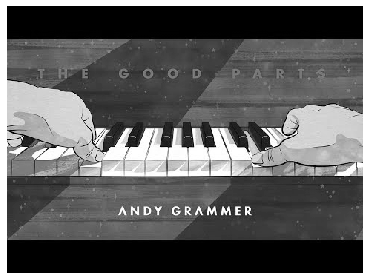

In [22]:
img = io.imread('data/images/1Wk8ZRgXQnY.jpg', as_gray=True)
img = skimage.img_as_int(img)
plt.axis('off')
io.imshow(img)
plt.show()

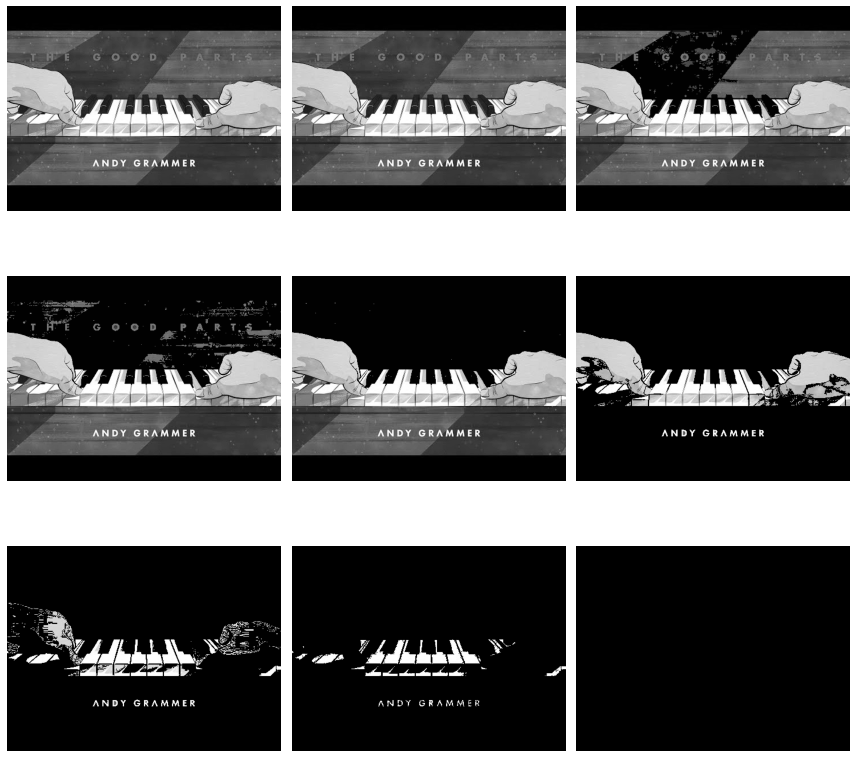

In [23]:
multiplier = 4500

res = []
for i in range(8): 
    tolerance = multiplier * i
    start_point = (int(img.shape[0]/2), int(img.shape[1]/2))
    # start_point = (0, 0)
    res.append(flood_fill(img, start_point, 255, tolerance=tolerance))


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
ax[0, 0].imshow(img, cmap=plt.cm.gray)
ax[0, 0].axis('off')
for i in range(8):
    m, n = np.unravel_index(i + 1, (3, 3))
    ax[m, n].imshow(res[i], cmap=plt.cm.gray)
    ax[m, n].axis('off')

fig.tight_layout()
plt.show()

In [24]:
def apply_flood(index, iterations=8, multiplier=4500):
    img = io.imread('data/images/{}.jpg'.format(index), as_gray=True)
    img = skimage.img_as_int(img)
    results = []
    for i in range(iterations):
        tolerance = multiplier * i
        start_point = (int(img.shape[0]/2), int(img.shape[1]/2)) # start from the middle
        img_temp = flood_fill(img, start_point, 255, tolerance=tolerance)
        unique, counts = np.unique(img_temp, return_counts=True)
        results.append(dict(zip(unique, counts))[255])
    return results

videos_df = mod_img(videos_df, apply_flood, colname=[f'flood_{i}' for i in range(8)])
videos_df.head(5)

100%|██████████| 2598/2598 [04:38<00:00,  9.34it/s]


,thumbnail_link,category_text,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7
video_id,,,,,,,,,,,,,,,,,
wnwF1FHybDQ,https://i.ytimg.com/vi/wnwF1FHybDQ/default.jpg,Comedy,"[0.61984324, -0.023169093, -0.16509528, -0.129...",2,"[person, person]","(person, 0.43971124)",person,11.798289,-131,26,3448,4977,8447,9219,69335,172800,172800
1Wk8ZRgXQnY,https://i.ytimg.com/vi/1Wk8ZRgXQnY/default.jpg,Music,"[0.071150824, -0.1588716, 0.070787266, -0.1663...",0,[],"(nan, -1)",NaN,11.539311,-160,1,22091,68489,74044,144588,160144,166034,172800
lsfzA7sWlOM,https://i.ytimg.com/vi/lsfzA7sWlOM/default.jpg,Gaming,"[0.17966352, 0.04218488, 0.31104606, -0.110772...",2,"[person, person]","(person, 0.9330134)",person,10.822090,-204,30,48050,129615,142426,161417,164727,172800,172800
X7flefV8tec,https://i.ytimg.com/vi/X7flefV8tec/default.jpg,Entertainment,"[0.3326259, 0.117587484, 0.038384244, -0.18782...",1,[person],"(person, 0.84617865)",person,11.684017,-111,43,100983,155206,165407,167709,168129,172616,172800
KJ12FVmumeA,https://i.ytimg.com/vi/KJ12FVmumeA/default.jpg,Sports,"[0.3614484, -0.14770822, 0.2532859, 0.04190903...",2,"[person, person]","(person, 0.86885333)",person,12.004378,-58,61,49560,102037,124828,141552,152752,161936,172800
